# Projet Data Mining : Bank Churn Prediction - Kaggle Competition</span>

# <span style="color:lightblue;">Importation des librairies</span>

In [302]:
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os
import pandas as pd
import seaborn as sns
import warnings
import xgboost as xgb
from catboost import CatBoostClassifier
from itertools import product
from lightgbm import LGBMClassifier
from scipy.stats import anderson, chi2_contingency, spearmanr
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report, confusion_matrix, roc_auc_score, roc_curve)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from itertools import combinations, product

In [169]:
# Pour supprimer les warnings
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.deprecation")


# <span style="color:lightblue;">Importation des bases de données</span>

In [344]:
data = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [345]:
data

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15713774.0,Hsieh,683.0,Germany,Male,49.0,7.0,123837.86,2.0,1.0,1.0,138700.75,1.0
1,1,15682533.0,Hs?eh,608.0,France,Female,30.0,10.0,0.00,2.0,1.0,1.0,146723.72,0.0
2,2,15791550.0,Tsou,539.0,France,Female,32.0,8.0,0.00,1.0,1.0,1.0,94873.60,0.0
3,3,15762762.0,Chiawuotu,530.0,Spain,Female,39.0,8.0,0.00,2.0,0.0,0.0,177896.93,0.0
4,4,15756475.0,Nnamdi,613.0,France,Female,45.0,10.0,0.00,2.0,1.0,1.0,116748.14,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,15660608.0,Ch'in,681.0,Spain,Male,31.0,1.0,0.00,2.0,1.0,1.0,125445.80,0.0
14996,14996,15767432.0,Fan,549.0,Germany,Male,34.0,7.0,134464.58,1.0,1.0,0.0,126535.92,0.0
14997,14997,15766896.0,Trevisano,550.0,France,Female,46.0,5.0,0.00,2.0,1.0,1.0,133897.32,0.0
14998,14998,15705412.0,Udegbulam,647.0,France,Female,25.0,4.0,141616.55,2.0,1.0,0.0,187597.98,0.0


In [346]:
test

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15797736.0,Chikwendu,591.0,Germany,Female,32.0,2.0,106881.50,2.0,1.0,0.0,122810.53
1,15001,15676515.0,Lai,553.0,Spain,Male,37.0,2.0,0.00,2.0,1.0,0.0,63736.17
2,15002,15701291.0,Folliero,646.0,France,Female,29.0,7.0,0.00,2.0,1.0,0.0,121866.87
3,15003,15594812.0,Trevisani,603.0,Germany,Male,49.0,8.0,131394.56,1.0,0.0,1.0,147059.28
4,15004,15791321.0,Ch'ien,645.0,Spain,Female,39.0,3.0,0.00,2.0,1.0,0.0,129975.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642063.0,Tung,694.0,Spain,Male,41.0,6.0,0.00,2.0,0.0,0.0,171378.77
9996,24996,15731267.0,Hsiao,614.0,France,Female,55.0,8.0,157597.61,1.0,1.0,0.0,70974.13
9997,24997,15673367.0,Manna,589.0,France,Male,41.0,4.0,0.00,2.0,1.0,1.0,123475.88
9998,24998,15626141.0,Chukwumaobim,543.0,Germany,Male,33.0,2.0,151659.52,1.0,1.0,1.0,86911.49



# <span style="color:lightblue;">Analyse exploratoire des données</span>

### Analyse des valeurs manquantes et types de données

In [347]:
print("\nInformations générales sur le dataset:")
data.info()


Informations générales sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


Il n'y a pas de valeurs manquantes dans le dataset

In [348]:
print("\nInformations générales sur test :")
test.info()


Informations générales sur test :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               10000 non-null  int64  
 1   CustomerId       10000 non-null  float64
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  float64
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  float64
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  float64
 10  HasCrCard        10000 non-null  float64
 11  IsActiveMember   10000 non-null  float64
 12  EstimatedSalary  10000 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory usage: 1015.8+ KB


### Analyse des valeurs aberrantes

In [349]:
data.describe(include = 'all')

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.000000,1.500000e+04,15000,15000.000000,15000,15000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
unique,NaN,NaN,755,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Ch'iu,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,311,NaN,9048,8422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,7499.500000,1.570073e+07,NaN,658.701800,NaN,NaN,37.660800,5.038800,42888.826095,1.589467,0.779800,0.497867,117892.175400,0.199333
std,4330.271354,1.162730e+06,NaN,80.238346,NaN,NaN,8.106408,2.810354,59695.877791,0.532430,0.414395,0.500012,45574.462515,0.399512
min,0.000000,1.557151e+05,NaN,431.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,3749.750000,1.563387e+07,NaN,602.000000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,82870.750000,0.000000
50%,7499.500000,1.569018e+07,NaN,661.000000,NaN,NaN,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123583.850000,0.000000
75%,11249.250000,1.575972e+07,NaN,709.000000,NaN,NaN,42.000000,7.000000,109844.810000,2.000000,1.000000,1.000000,157567.370000,0.000000


#### Remarques:
- Il y a deux variables qualitatives (**Geography** et **Gender**). Le one-hot encoding ne posera pas de problème de dimensionnalité puisque ces variables n’ont respectivement que 2 et 3 valeurs uniques, ce qui ajoutera seulement 3 colonnes supplémentaires.
- Les variables **HasCrCard** et **IsActiveMemeber** sont également catégoriques mais sont actuellement au format flottant ; elles doivent donc être converties en variables catégoriques.
- Les scores de crédit varient normalement entre 300 et 900. Cependant, la valeur maximale observée dans les données est de 4818, ce qui indique la présence de valeurs aberrantes.
- Un **balance** de 207034,96 semble être une valeur élevée. Un boxplot sera utilisé pour déterminer si cela est normal ou s’il s’agit d’une anomalie.
- Une valeur de **NumOfProducts** égale à 6 pourrait également être considérée comme élevée et nécessitera une vérification.
- La même remarque s’applique à **EstimatedSalary** ; il serait utile d’examiner la distribution pour détecter d’éventuelles anomalies.

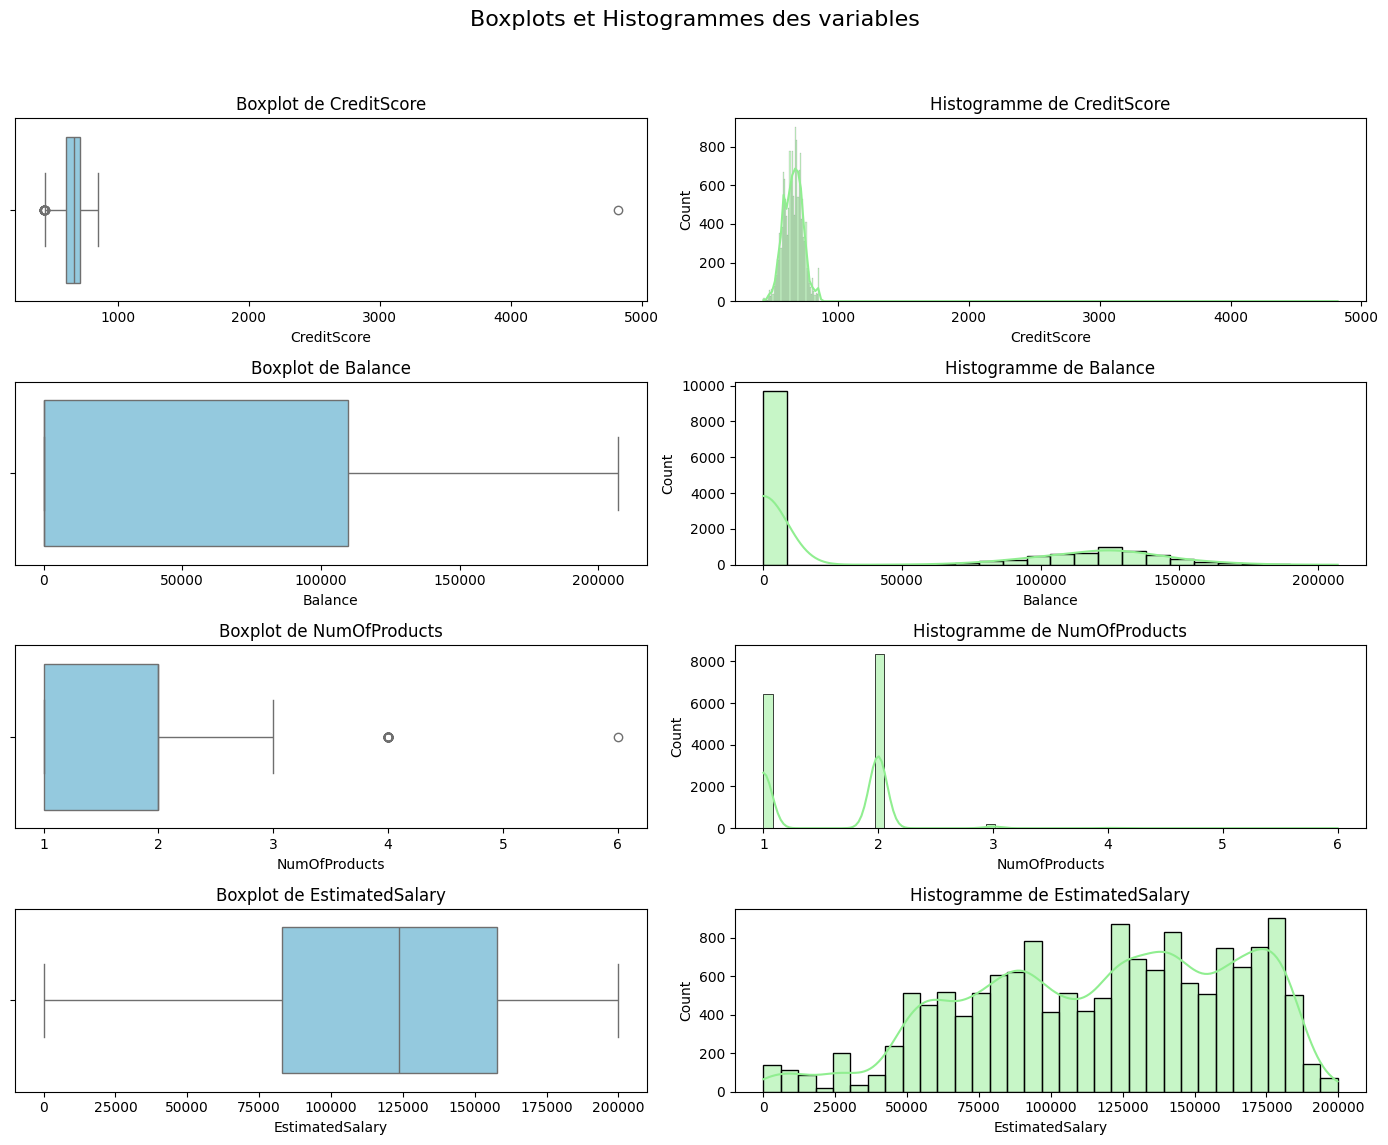

In [350]:
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
fig.suptitle("Boxplots et Histogrammes des variables", fontsize = 16)

# Variables qui nous interessent
variables = ["CreditScore", "Balance", "NumOfProducts", "EstimatedSalary"]

for i, var in enumerate(variables):

  sns.boxplot(x = data[var], ax = axes[i][0], color = "skyblue")
  axes[i][0].set_title(f"Boxplot de {var}")

  sns.histplot(x = data[var], kde = True, ax = axes[i][1], color = "lightgreen")
  axes[i][1].set_title(f"Histogramme de {var}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Les valeurs semblent être logiques, à l’exception du **CreditScore**, qui nécessite un traitement spécifique. Cependant, après avoir testé la suppression de cette valeur aberrante, nous avons constaté une baisse significative des performances des modèles. Par conséquent, nous avons décidé de la conserver.

### Vérification des doublons 

In [351]:
selected_columns = [col for col in data.columns if col not in ['id', 'Exited']]
duplicate_count = data.duplicated(subset=selected_columns).sum()

print(f"Il y a {duplicate_count} individus qui présentent exactement les mêmes caractéristiques.")

Il y a 0 individus qui présentent exactement les mêmes caractéristiques.


### Analyse de la variable cible Exited

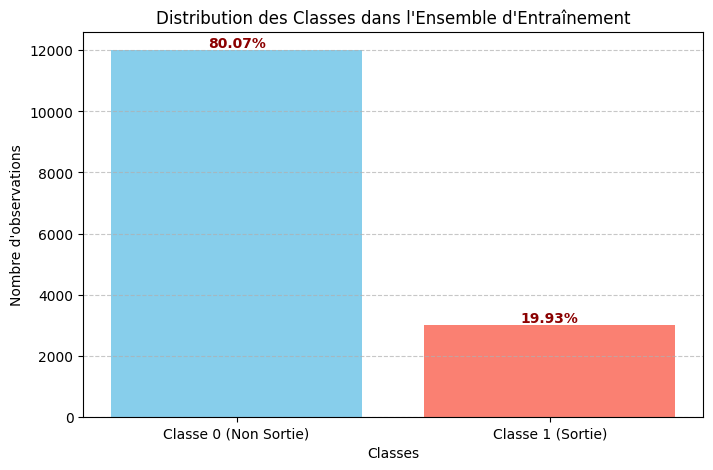

In [352]:
class_counts = data['Exited'].value_counts()

plt.figure(figsize=(8, 5))
bars = plt.bar(class_counts.index, class_counts.values, color=['skyblue', 'salmon'])

plt.xlabel('Classes')
plt.ylabel('Nombre d\'observations')
plt.xticks([0, 1], ['Classe 0 (Non Sortie)', 'Classe 1 (Sortie)'])
plt.title('Distribution des Classes dans l\'Ensemble d\'Entraînement')

total = class_counts.sum()
for i, value in enumerate(class_counts.values):
    percentage = (value / total) * 100
    plt.text(i, value + 0.05, f'{percentage:.2f}%', ha='center', va='bottom', fontweight='bold', color='darkred')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

On remarque qu'il ya un désequilibre de classe. on testera quelques techniques de rééchantillonnage par la suite

In [353]:
# Liste des featutres numériques dans data
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'NumOfProducts']
# Liste des features catégorielles dans data
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

### Analyse bivariée des variables 

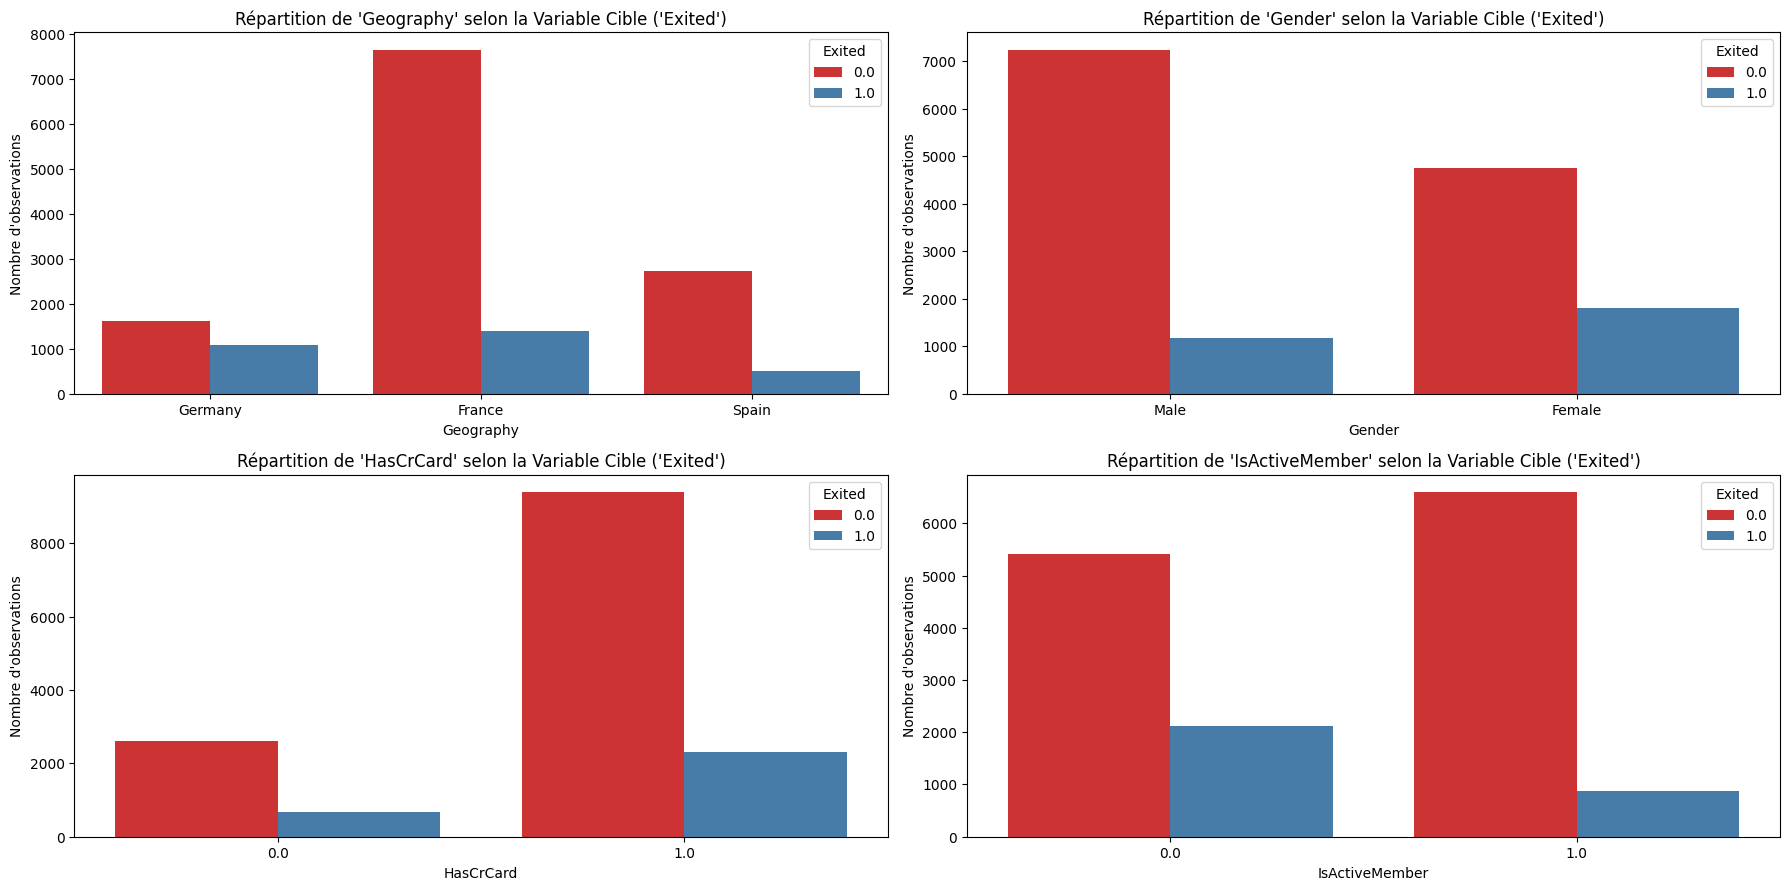

In [354]:
plt.figure(figsize=(18, 13))

# Visualiser chaque features catégorielle selon la variable cible
for i, feature in enumerate(categorical_features):
    plt.subplot(3, 2, i+1)
    sns.countplot(x=data[feature], hue=data['Exited'], palette='Set1', dodge=True)
    plt.title(f"Répartition de '{feature}' selon la Variable Cible ('Exited')")
    plt.xlabel(feature)
    plt.ylabel('Nombre d\'observations')

plt.tight_layout()
plt.show()

- La France domine en nombre de clients
- L'Allemagne montre le plus fort taux de départ proportionnel
- Les femmes partent proportionnellement plus souvent
- Avoir une carte de crédit fidélise
- L'inactivité est un signal fort de départ futur

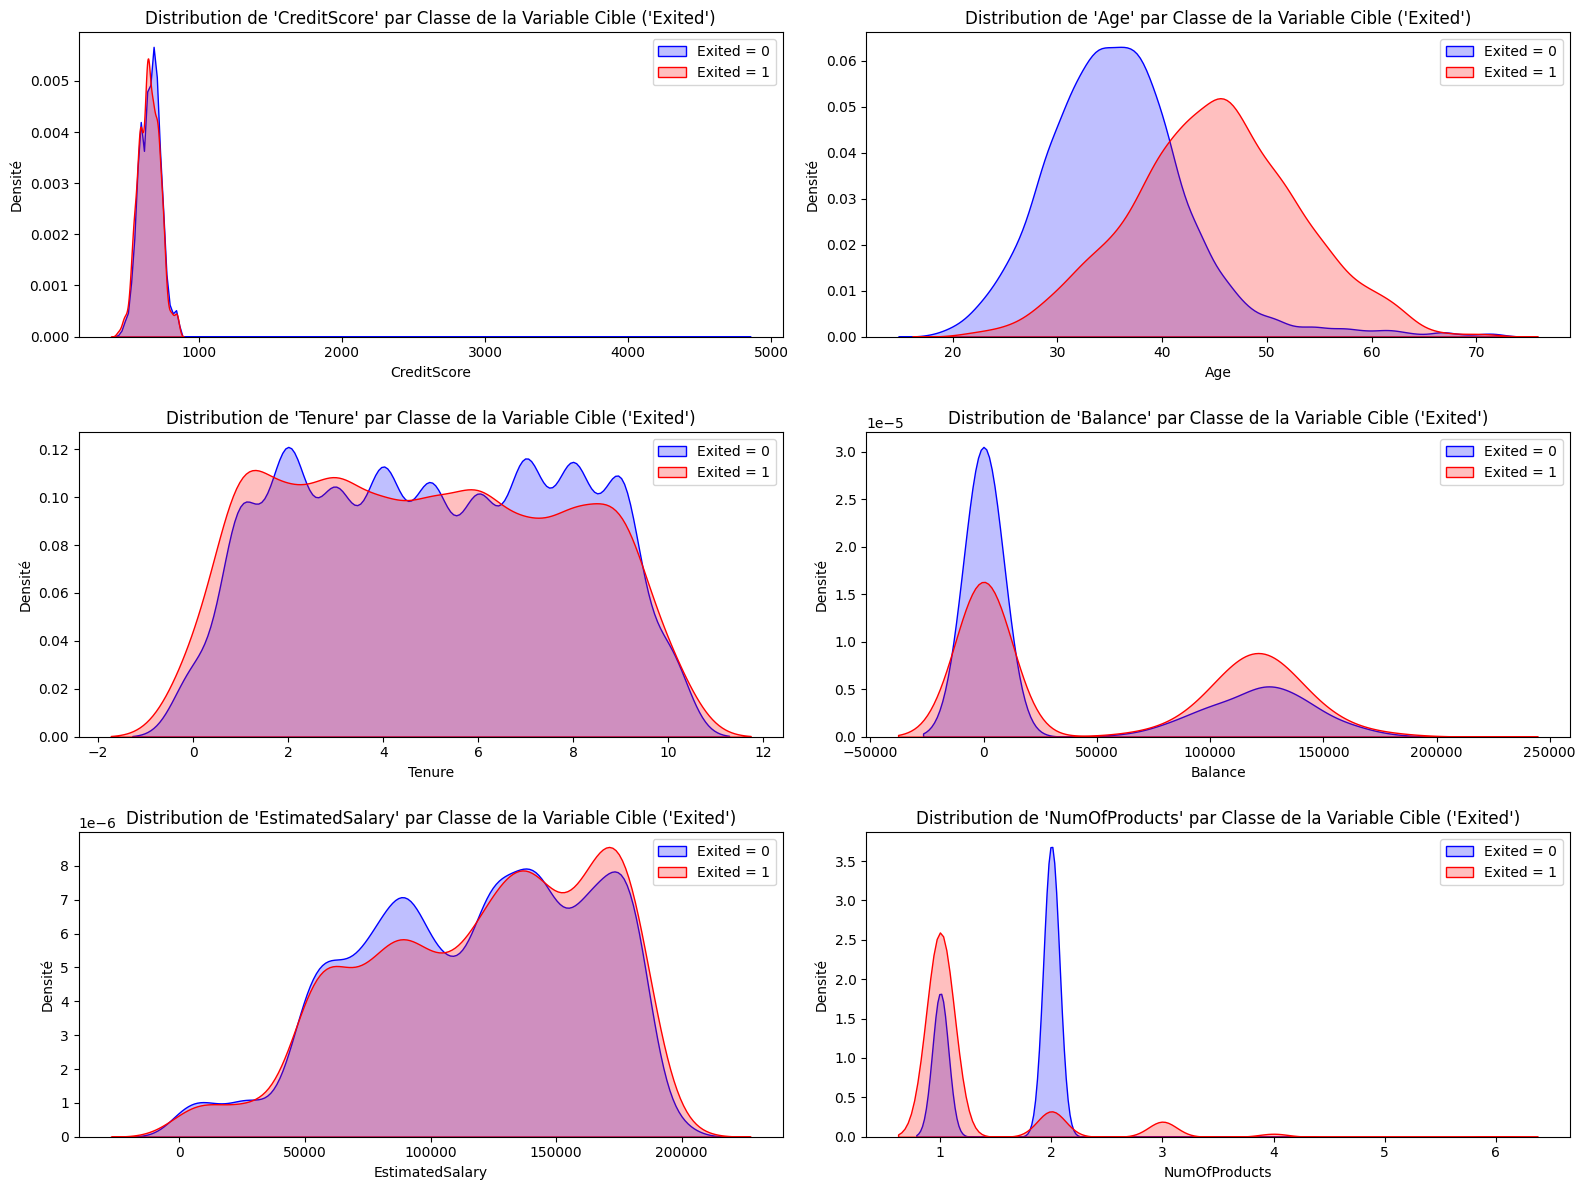

In [355]:
plt.figure(figsize=(16, 12))

# Visualiser la distribution de chaque caractéristique numérique selon la variable cible
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 2, i+1)
    sns.kdeplot(data[feature][data['Exited'] == 0], label='Exited = 0', color='blue', fill=True)
    sns.kdeplot(data[feature][data['Exited'] == 1], label='Exited = 1', color='red', fill=True)
    plt.title(f"Distribution de '{feature}' par Classe de la Variable Cible ('Exited')")
    plt.xlabel(feature)
    plt.ylabel('Densité')
    plt.legend()

plt.tight_layout()
plt.show()

* Les distributions de la variable CreditScore sont très similaires pour les deux groupes (Exited = 0 et Exited = 1) .Donc, le score de crédit ne semble pas fortement différencier les clients qui quittent ou non la banque. Il pourrait avoir une influence mineure.
* La distribution des âges est clairement différente entre les deux groupes : les clients exités (Exited = 1) sont majoritairement plus âgés et les clients non exités (Exited = 0) sont souvent plus jeunes. Donc l'âge est une variable discriminante. Les clients plus âgés sont plus susceptibles de quitter la banque.
* Les distributions de Tenure (ancienneté) sont très proches pour les deux groupes. Donc l'ancienneté n'est pas un facteur clé pour distinguer les clients qui quittent ou restent ce qui est un peu étonnant.
* Les clients qui quittent (Exited = 1) ont tendance à avoir des soldes plus élevés, tandis que ceux qui restent (Exited = 0) ont une densité significative autour de zéro (peu ou pas de solde). Donc le solde bancaire est un facteur important: les clients ayant des soldes élevés pourraient quitter en raison d'un mécontentement peut etre  ou d'une recherche de meilleures opportunités ailleurs.
* Les distributions de EstimatedSalary sont presque identiques pour les deux groupes. Donc le salaire estimé ne semble pas avoir d'impact significatif sur la probabilité de quitter ou rester.
* Les clients ayant un seul produit sont majoritairement ceux qui quittent (Exited = 1). Ceux avec 2 produits restent majoritairement (Exited = 0). Peu de clients ont 3 ou 4 produits => Les clients ayant plus de produits sont plus fidèles, tandis que ceux avec un seul produit sont plus susceptibles de quitter

### Analyse des corrélations (variables numériques)

In [356]:
# Variables qualtitatives et quantitatives
categorical_features = ['Geography', 'Gender']
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

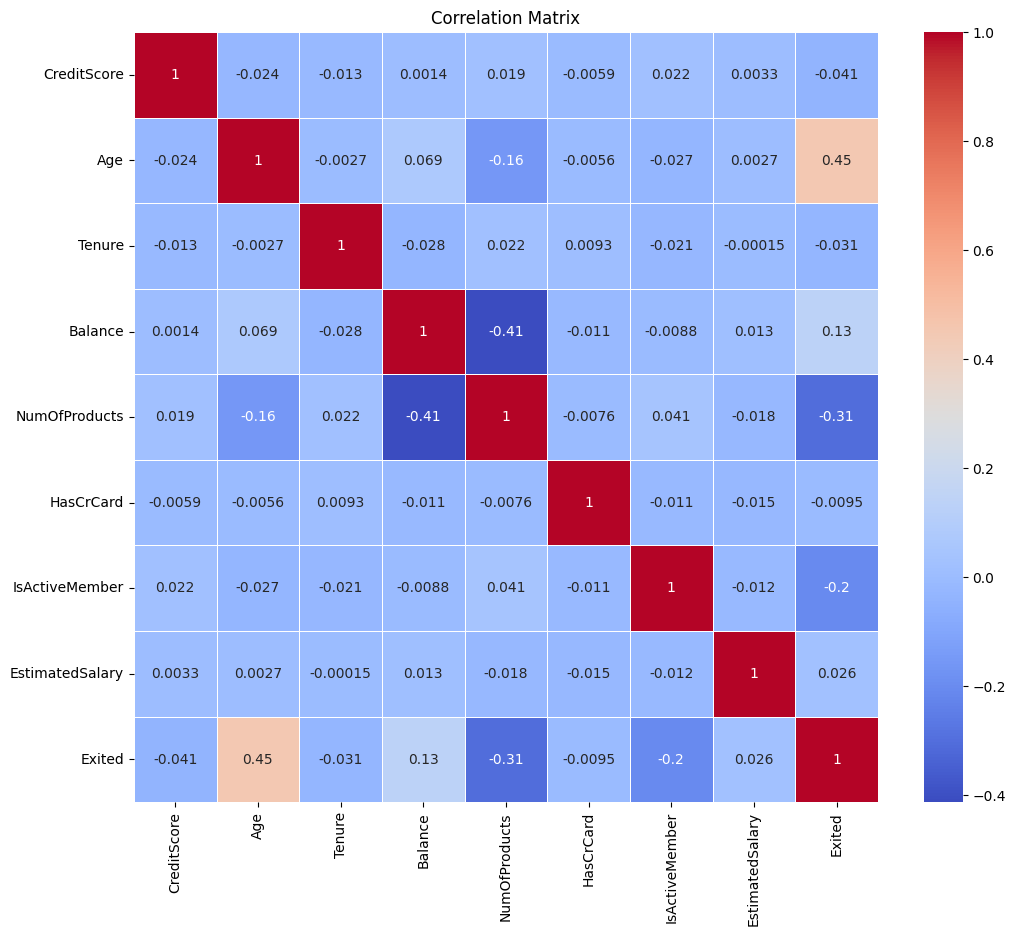

In [357]:
correlations = data[numerical_features + ['Exited']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

- On remarque qu'il y a peu de corrélations entre les variables numériques.
- La corrélation entre **`Age`** et **`Exited`** est de **0.45**, ce qui est relativement élevé. Cela suggère que l'âge est une variable très importante pour prédire si un client quitte la banque.
- **`Balance`** a une corrélation de **0.13** avec **`Exited`**, ce qui indique que les clients ayant un certain niveau de balance sont plus susceptibles de quitter.
- **`NumOfProducts`** a une **corrélation négative (-0.31)** avec **`Exited`**, ce qui pourrait indiquer que plus un client utilise de produits, moins il est susceptible de quitter. 
- **`IsActiveMember`** a une **corrélation négative (-0.2)** avec **`Exited`**. Cela montre que l'engagement est un facteur important pour la rétention des clients.
- Il existe une **corrélation négative** entre **`NumOfProducts`** et **`Balance`**, ainsi qu’entre **`NumOfProducts`** et **`Age`**.
- Nous analyserons par la suite la corrélation avec les variables catégoriques.

### Analyse des corrélations (variables catégorielles)

In [358]:
# Cramer's V pour correlation entre variables categoriques
def cramers_v(contingency_table):
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    k_corr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

categorical_correlations = {}

# Corrélations entre variables catégoriques
for i, cat1 in enumerate(categorical_features):
    for cat2 in categorical_features[i+1:]:
        contingency_table = pd.crosstab(data[cat1], data[cat2])
        categorical_correlations[(cat1, cat2)] = cramers_v(contingency_table)

# Corrélations entre chaque variable catégorielle et la variable cible (Exited)
for cat in categorical_features:
    contingency_table = pd.crosstab(data[cat], data['Exited'])
    categorical_correlations[(cat, 'Exited')] = cramers_v(contingency_table)

categorical_correlations

{('Geography', 'Gender'): 0.02186418822932761,
 ('Geography', 'Exited'): 0.23569787581852736,
 ('Gender', 'Exited'): 0.1687277872702606}

- Il y a très peu d'association entre la région géographique et le genre des clients
- La corrélation entre **`Geography`** et **`Exited`** est de **0.2357**. Cela indique une corrélation modérée entre la localisation géographique et la probabilité de quitter la banque. La région du client a donc un impact non négligeable sur la rétention.
- La corrélation entre **`Gender`** et **`Exited`** est de **0.1688**. Cela montre une corrélation faible à modérée entre le genre du client et sa décision de quitter la banque. 

Dans ce qui suit, nous allons encoder les variables catégoriques, puis effectuer un test de corrélation de Spearman afin de vérifier si les variables numériques et catégoriques sont corrélées entre elles.

### Test de normalité des variables numériques


Avant de mettre à l’échelle les variables numériques, nous allons tester si elles suivent une loi normale ou non. Cela permettra de déterminer s’il est préférable de les normaliser avec un MinMaxScaler ou de les standardiser avec un StandardScaler.

In [359]:
# Variables numériques continues et binaires
numerical_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts']
binary_features = ['HasCrCard', 'IsActiveMember']

# Variables catégoriques
categorical_features = ['Geography', 'Gender']

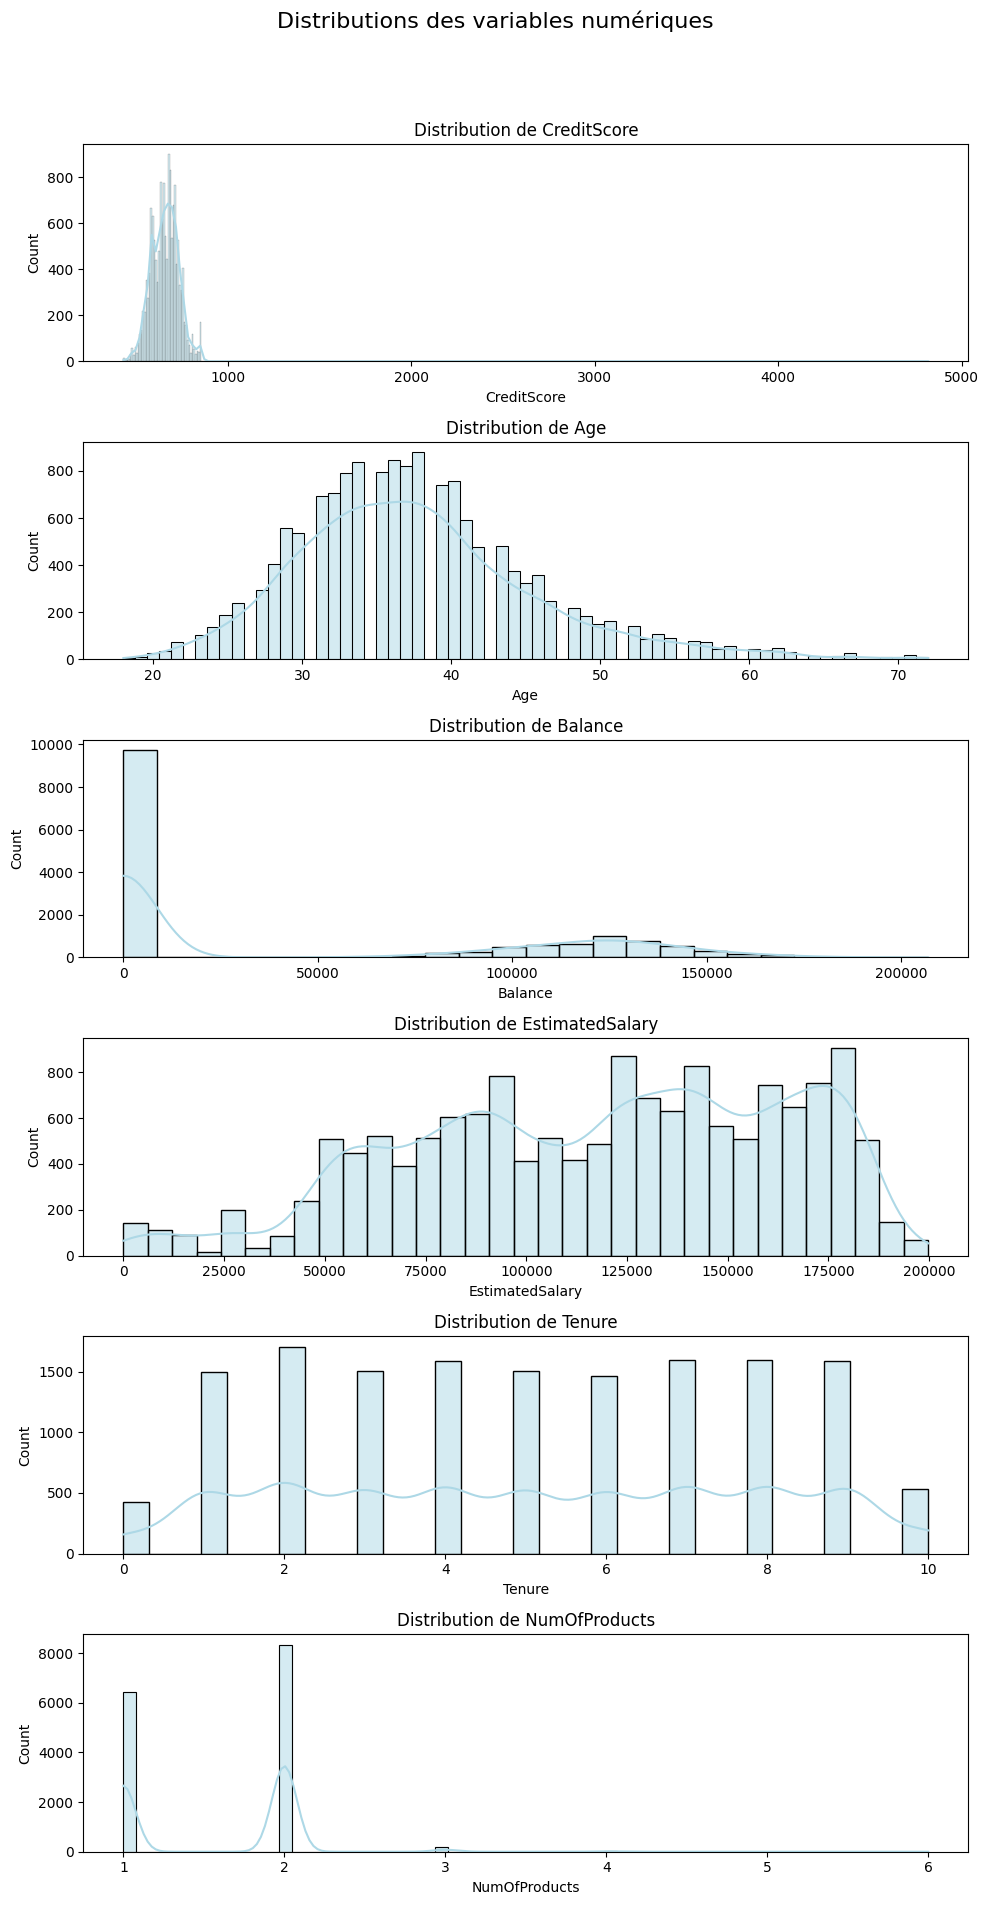

In [360]:
# Visualisation de la distribution des variables numeriques
fig, axes = plt.subplots(len(numerical_features), 1, figsize=(10, 20))
fig.suptitle("Distributions des variables numériques", fontsize=16)

# Plot histograms
for i, feature in enumerate(numerical_features):
    sns.histplot(data[feature], kde=True, ax=axes[i], color="lightblue")
    axes[i].set_title(f"Distribution de {feature}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

On remarque que la plupart des variables ne suivent pas une distribution normale. On fera un test de normalité pour vérifier ceci.

In [361]:
# verifions la normalite des variables numeriques avec le test Anderson-Darling
anderson_results = {}
for feature in numerical_features:
    result = anderson(data[feature].dropna())
    anderson_results[feature] = result.statistic

anderson_results

{'CreditScore': 47.657945175007626,
 'Age': 128.9802740603409,
 'Balance': 2394.6688929559386,
 'EstimatedSalary': 135.85417571817925,
 'Tenure': 240.46111283013488,
 'NumOfProducts': 2349.7524345467464}

On a obtenu des valeurs tres grandes ce qui signifie que les variables s'éloignent beaucoup de la distribution normale. Pour normaliser les données, on va alors utiliser le MinmaxScaler au lieu de StandardScaler.

### Encodage des variables et normalisation

In [362]:
# ColumnTransformer avec OneHotEncoder et MinMaxScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', MinMaxScaler(), numerical_features)
    ]
)

encoded_normalized_data_full = preprocessor.fit_transform(data)
encoded_normalized_test = preprocessor.transform(test)

encoded_features = preprocessor.get_feature_names_out()
data_transformed_full = pd.DataFrame(encoded_normalized_data_full, columns=encoded_features)
test_transformed = pd.DataFrame(encoded_normalized_test, columns=encoded_features)

# Ajouter les variables binaires au DataFrame final
binary_data_full = data[binary_features].reset_index(drop=True)
binary_data_test = test[binary_features].reset_index(drop=True)

# Concaténer les variables binaires avec les données encodées et normalisées
data_transformed_full = pd.concat([data_transformed_full, binary_data_full], axis=1)
test_transformed = pd.concat([test_transformed, binary_data_test], axis=1)

data_transformed_full

,cat__Geography_Germany,cat__Geography_Spain,cat__Gender_Male,num__CreditScore,num__Age,num__Balance,num__EstimatedSalary,num__Tenure,num__NumOfProducts,HasCrCard,IsActiveMember
0,1.0,0.0,1.0,0.057442,0.574074,0.598150,0.694315,0.7,0.2,1.0,1.0
1,0.0,0.0,0.0,0.040346,0.222222,0.000000,0.734480,1.0,0.2,1.0,1.0
2,0.0,0.0,0.0,0.024618,0.259259,0.000000,0.474904,0.8,0.0,1.0,1.0
3,0.0,1.0,0.0,0.022567,0.388889,0.000000,0.890541,0.8,0.2,0.0,0.0
4,0.0,0.0,0.0,0.041486,0.500000,0.000000,0.584414,1.0,0.2,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,1.0,1.0,0.056987,0.240741,0.000000,0.627957,0.1,0.2,1.0,1.0
14996,1.0,0.0,1.0,0.026898,0.296296,0.649478,0.633414,0.7,0.0,1.0,0.0
14997,0.0,0.0,0.0,0.027126,0.518519,0.000000,0.670268,0.5,0.2,1.0,1.0
14998,0.0,0.0,0.0,0.049236,0.129630,0.684022,0.939107,0.4,0.2,1.0,0.0


In [363]:
def convert_encoded_columns_to_int(df):
    for col in df.columns:
        if 'cat__' in col:
            df[col] = df[col].astype(int)
    return df

In [364]:
data_transformed_full = convert_encoded_columns_to_int(data_transformed_full)
test_transformed = convert_encoded_columns_to_int(test_transformed)

data_transformed_full.head()

,cat__Geography_Germany,cat__Geography_Spain,cat__Gender_Male,num__CreditScore,num__Age,num__Balance,num__EstimatedSalary,num__Tenure,num__NumOfProducts,HasCrCard,IsActiveMember
0,1,0,1,0.057442,0.574074,0.59815,0.694315,0.7,0.2,1.0,1.0
1,0,0,0,0.040346,0.222222,0.00000,0.734480,1.0,0.2,1.0,1.0
2,0,0,0,0.024618,0.259259,0.00000,0.474904,0.8,0.0,1.0,1.0
3,0,1,0,0.022567,0.388889,0.00000,0.890541,0.8,0.2,0.0,0.0
4,0,0,0,0.041486,0.500000,0.00000,0.584414,1.0,0.2,1.0,1.0


Maintenant qu'on a encoder les variable categoriques, on peut vérifier les corrélations entre les variables num et cat avec le test de Spearman :

In [365]:
# corrélations entre les variables catégorielles encodées et les variables numériques non normalisées
combined_df = pd.concat([data_transformed_full, data[numerical_features]], axis=1)
combined_df = combined_df.dropna().reset_index(drop=True)

encoded_categorical_features = [feature for feature in encoded_features if 'cat__' in feature]
original_numerical_features = numerical_features

num_cat_correlations_transformed = {}

# Calcul des corrélations de Spearman entre les variables numériques et les variables catégorielles encodées
for num in original_numerical_features:
    for cat in encoded_categorical_features:
        categorical_data = combined_df[cat]
        numerical_data = combined_df[num]

        corr, _ = spearmanr(numerical_data, categorical_data)
        num_cat_correlations_transformed[(num, cat)] = corr

num_cat_correlation = pd.DataFrame.from_dict(num_cat_correlations_transformed, orient='index', columns=['Spearman Correlation'])
num_cat_correlation

,Spearman Correlation
"(CreditScore, cat__Geography_Germany)",-0.004325
"(CreditScore, cat__Geography_Spain)",0.002703
"(CreditScore, cat__Gender_Male)",0.000028
"(Age, cat__Geography_Germany)",0.111475
"(Age, cat__Geography_Spain)",-0.016160
"(Age, cat__Gender_Male)",-0.069814
"(Balance, cat__Geography_Germany)",0.611684
"(Balance, cat__Geography_Spain)",-0.156793
"(Balance, cat__Gender_Male)",-0.003169
"(EstimatedSalary, cat__Geography_Germany)",0.018010


- La corrélation entre **Balance** et **cat_Geography_Germany** est relativement élevée (0.611684), indiquant une association modérée entre ces deux variables.
- D'autres corrélations, telles que celles entre **NumOfProducts** et **cat_Geography_Germany** (-0.157979), montrent également un certain niveau d'association.
- La plupart des autres corrélations sont faibles, proches de zéro, ce qui suggère qu'il y a peu ou pas de relation linéaire entre les variables concernées.

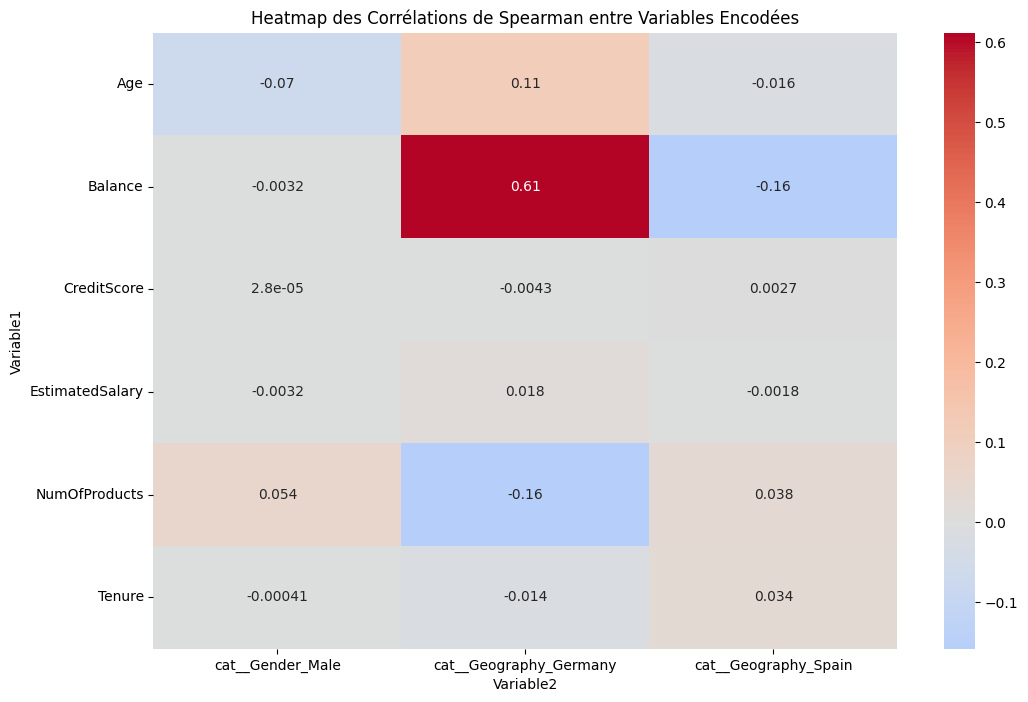

In [366]:
# Heatmap des correlations
num_cat_correlation.reset_index(inplace=True)
num_cat_correlation[['Variable1', 'Variable2']] = pd.DataFrame(num_cat_correlation['index'].tolist(), index=num_cat_correlation.index)
num_cat_correlation.drop(columns=['index'], inplace=True)

correlation_matrix = num_cat_correlation.pivot(index='Variable1', columns='Variable2', values='Spearman Correlation')

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Heatmap des Corrélations de Spearman entre Variables Encodées")
plt.show()

# <span style="color:lightblue;">Modélisation</span>


### Séparation Train-Validation

Dans les étapes précédentes, nous avons encodé et normalisé l’ensemble des datasets (data et test). Cependant, comme nous avons séparé data en ensembles d’entraînement et de validation, nous allons cette fois appliquer la transformation uniquement à X_train et ajuster les transformations sur X_val afin d’éviter tout data leakage.

In [367]:
# Define features and target variable
X = data.drop(columns=['id', 'CustomerId', 'Surname', 'Exited'])
y = data['Exited']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [368]:
# ColumnTransformer avec OneHotEncoder et MinMaxScaler
encoded_normalized_train_only = preprocessor.fit_transform(X_train)
encoded_normalized_val_only = preprocessor.transform(X_val)

X_train_transformed = pd.DataFrame(encoded_normalized_train_only, columns=encoded_features)
X_val_transformed = pd.DataFrame(encoded_normalized_val_only, columns=encoded_features)

# Ajouter les variables binaires au DataFrame final
X_train_binary = X_train[binary_features].reset_index(drop=True)
X_val_binary = X_val[binary_features].reset_index(drop=True)

# Concaténer les variables binaires avec les données encodées et normalisées
X_train_transformed = pd.concat([X_train_transformed, X_train_binary], axis=1)
X_val_transformed = pd.concat([X_val_transformed, X_val_binary], axis=1)

X_train_transformed, X_val_transformed

(       cat__Geography_Germany  cat__Geography_Spain  ...  HasCrCard  IsActiveMember
 0                         0.0                   0.0  ...        1.0             0.0
 1                         0.0                   0.0  ...        1.0             0.0
 2                         0.0                   0.0  ...        1.0             0.0
 3                         1.0                   0.0  ...        1.0             0.0
 4                         0.0                   0.0  ...        1.0             1.0
 ...                       ...                   ...  ...        ...             ...
 11995                     0.0                   0.0  ...        1.0             1.0
 11996                     1.0                   0.0  ...        1.0             1.0
 11997                     0.0                   1.0  ...        1.0             0.0
 11998                     0.0                   1.0  ...        1.0             0.0
 11999                     0.0                   0.0  ...        

In [369]:
X_train_transformed = convert_encoded_columns_to_int(X_train_transformed)
X_val_transformed = convert_encoded_columns_to_int(X_val_transformed)

X_train_transformed

,cat__Geography_Germany,cat__Geography_Spain,cat__Gender_Male,num__CreditScore,num__Age,num__Balance,num__EstimatedSalary,num__Tenure,num__NumOfProducts,HasCrCard,IsActiveMember
0,0,0,1,0.030545,0.351852,0.000000,0.862517,0.2,0.2,1.0,0.0
1,0,0,0,0.057670,0.666667,0.597445,0.441595,1.0,0.0,1.0,0.0
2,0,0,1,0.034420,0.370370,0.639270,0.388390,0.4,0.2,1.0,0.0
3,1,0,1,0.029861,0.314815,0.602740,0.436230,0.5,0.0,1.0,0.0
4,0,0,1,0.058810,0.888889,0.000000,0.481556,0.3,0.2,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
11995,0,0,1,0.037839,0.314815,0.000000,0.479108,0.5,0.2,1.0,1.0
11996,1,0,0,0.095509,0.407407,0.580315,0.903959,0.2,0.2,1.0,1.0
11997,0,1,1,0.062685,0.166667,0.000000,0.301639,0.5,0.2,1.0,0.0
11998,0,1,1,0.059950,0.388889,0.000000,0.565115,0.5,0.2,1.0,0.0


### <span style="color:lightyellow;">Fonctions pour optimiser l'entrainement et la soumission des prédictions
</span>


In [370]:
# Fonction pour effectuer une validation croisée sur un modèle et retourner les AUC scores.
def cross_validate_model(model, X, y, cv_folds=5):
    print(f"Starting cross-validation with {cv_folds} folds...")
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values

    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    auc_scores = []

    for train_index, val_index in skf.split(X, y):
        # Split the data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict probabilities
        y_val_pred_prob = model.predict_proba(X_val)[:, 1]
        
        # Calculate AUC for this fold
        auc_score = roc_auc_score(y_val, y_val_pred_prob)
        auc_scores.append(auc_score)

    # Calculate mean and standard deviation of AUC scores
    scores_mean = np.mean(auc_scores)
    scores_std = np.std(auc_scores)

    print(f"Scores AUC of each fold : {auc_scores}")
    print(f"Mean of AUC scores : {scores_mean:.4f}")
    print(f"Standard Deviation of AUC scores : {scores_std:.4f}")
    
    return scores_mean, scores_std

In [371]:
# Fonction pour entraîner un modèle et évaluer l'AUC sur l'ensemble de validation
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, model_name):

    # Create the 'models' folder if it doesn't exist
    models_dir = os.path.join(os.getcwd(), 'models')
    os.makedirs(models_dir, exist_ok=True)

    # Full path to the model file
    model_path = os.path.join(models_dir, model_name)
    
    try:
        # Check if a pre-trained model exists
        print(f"Looking for saved model '{model_path}'...")
        model = joblib.load(model_path)
        print(f"Loaded pre-trained model from {model_path}.")
    except FileNotFoundError:
        print(f"No pre-trained model found. Training model from scratch...")


    model.fit(X_train, y_train)

    joblib.dump(model, model_path)
    print(f"Model saved as {model_path}.")
    
    y_val_pred_prob = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_val_pred_prob)
    print(f"AUC Score of the model {model.__class__.__name__}: {auc_score:.4f}")
    
    return model, auc_score

In [373]:
def evaluate_classification_model_with_comparison(model, X_train, y_train, X_val, y_val):
    """
    Evaluate a classification model by generating confusion matrix, classification report,
    and comparing ROC curves for both training and validation datasets.

    Parameters:
        model: Trained classification model
        X_train: Training feature dataset
        y_train: Training target dataset
        X_val: Validation feature dataset
        y_val: Validation target dataset

    Returns:
        conf_matrix: Confusion matrix for validation set
        classif_report: Classification report for validation set
    """

    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    y_val_pred_prob = model.predict_proba(X_val)[:, 1]
    y_val_pred = model.predict(X_val)

    auc_train = roc_auc_score(y_train, y_train_pred_prob)
    auc_val = roc_auc_score(y_val, y_val_pred_prob)

    print(f"AUC Score on Training Set: {auc_train:.4f}")
    print(f"AUC Score on Validation Set: {auc_val:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', ax=axes[0])
    axes[0].set_xlabel('Classe Prédite')
    axes[0].set_ylabel('Classe Réelle')
    axes[0].set_title(f'Matrice de Confusion pour le Modèle {model.__class__.__name__}')

    # ROC Curve
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_prob)
    axes[1].plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.4f})', color='blue')
    axes[1].plot(fpr_val, tpr_val, label=f'Validation ROC (AUC = {auc_val:.4f})', color='green', linestyle='--')
    axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', label='Baseline (AUC = 0.5)')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve Comparison')
    axes[1].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    # classification report for validation set
    classif_report = classification_report(y_val, y_val_pred)
    print(f"Classification Report for {model.__class__.__name__}:\n")
    print(classif_report)

    return conf_matrix, classif_report

In [374]:
# Fonction pour entraîner un modèle, prédire sur l'ensemble de test, et sauvegarder les prédictions dans un fichier CSV
def save_predictions_to_csv(model, X_test, test_id, output_file):
    
    # Prédire les probabilités sur l'ensemble de test
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]

    predictions_df = pd.DataFrame({
        'id': test_id,
        'Exited': y_test_pred_prob
    })

    # Sauvegarde des prédictions dans un fichier CSV
    predictions_df.to_csv(output_file, index=False)
    print(f"Predictions were saved in the file : {output_file}")

    return predictions_df

In [375]:
# Fonction pour entraîner le dataset train complet avec le modèle selectionne, prédire sur l'ensemble de test, et sauvegarder les prédictions dans un fichier CSV
def train_and_save_final_predictions(model, X_full, y_full, X_test, test_id, model_name, output_file):

    models_dir = os.path.join(os.getcwd(), 'models')
    os.makedirs(models_dir, exist_ok=True)
    
    model_path = os.path.join(models_dir, model_name)
    
    try:
        # Check if a pre-trained model exists
        print(f"Looking for saved model '{model_path}'...")
        model = joblib.load(model_path)
        print(f"Loaded pre-trained model from {model_path}.")
    except FileNotFoundError:
        print(f"No pre-trained model found. Training model from scratch...")    
    
        model.fit(X_full, y_full)
        print(f"The model {model.__class__.__name__} is trained on the full train dataset")

        # Save the model for future use
        joblib.dump(model, model_path)
        print(f"Model saved as {model_path}.")
    
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    predictions_df = pd.DataFrame({'id': test_id, 'Exited': y_test_pred_prob})

    predictions_df.to_csv(output_file, index=False)
    print(f"Predictions were saved in the file : {output_file}")

    return predictions_df

In [377]:
def tune_hyperparameters(objective, n_trials=200, study_name="optuna_study", resume_study=False):
    """
    This function tunes hyperparameters using Optuna.
    
    Args:
    - objective: The objective function that Optuna will call.
    - n_trials: Number of trials to run for Optuna.
    - study_name: Name of the study (for saving and reloading).
    - resume_study: If True, resume from an existing study if it exists.

    Returns:
    - best_params: The best parameters found during the study.
    - best_score: The best AUC score achieved.
    - study: The Optuna study (to view the history of trials).
    """
    # Get the current directory where the script is running
    base_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
    
    # Create the 'study' folder if it doesn't exist
    studies_dir = os.path.join(base_dir, 'study')
    os.makedirs(studies_dir, exist_ok=True)
    
    # Full path to the study file
    study_path = os.path.join(studies_dir, f"{study_name}.pkl")

    if resume_study:
        try:
            study = joblib.load(study_path)
            print(f"Resuming previous study '{study_name}' with {len(study.trials)} trials.")
        except FileNotFoundError:
            print(f"No previous study found. Starting new study '{study_name}'.")
            study = optuna.create_study(direction='maximize')
    else:
        study = optuna.create_study(direction='maximize')

    study.optimize(objective, n_trials=n_trials)
    
    # Save the study to the designated path
    joblib.dump(study, study_path)
    print(f"Study saved to {study_path}")

    best_params = study.best_params
    best_score = study.best_value

    print(f"Best AUC: {best_score}")
    print(f"Best Parameters: {best_params}")
    
    return best_params, best_score, study


# <span style="color:lightblue;">Random Forest</span>

#### Test de Hyperparameter tuning avec Optuna

In [219]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train_transformed, y_train)
    y_val_pred_prob = model.predict_proba(X_val_transformed)[:, 1]
    auc_score = roc_auc_score(y_val, y_val_pred_prob)
    return auc_score

In [221]:
best_rf_params, best_rf_score, rf_study = tune_hyperparameters(
    objective=objective_rf, 
    n_trials=0, # n_trials est 1000 de base mais on a mis 0 commen ca quand on relance le code, on a pas 1000 nouvelles iterations qui se lancent
    study_name="rf_study_v2", 
    resume_study=True
)

Resuming previous study 'rf_study_v2' with 1000 trials.
Study saved to /home/chahla/Bank-Churn-Prediction/src/study/rf_study_v2.pkl
Best AUC: 0.9293102902040299
Best Parameters: {'n_estimators': 110, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}


In [381]:
# Create the RandomForest model with best parameters
rf_model_optuna = RandomForestClassifier(
    n_estimators=110, 
    max_depth=10, 
    min_samples_split=20, 
    min_samples_leaf=1, 
    max_features='log2', 
    bootstrap=True, 
    random_state=42
)

# Cross-Validate the Model
auc_mean, auc_std = cross_validate_model(rf_model_optuna, X_train_transformed, y_train)
rf_model_optuna, auc_score_random_forest_base = train_and_evaluate_model(rf_model_optuna, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'rf_optuna_base.pkl')

Starting cross-validation with 5 folds...
Scores AUC of each fold : [0.9254269578825611, 0.9327332756604036, 0.9398982470366984, 0.9423320795734916, 0.9309652081643921]
Mean of AUC scores : 0.9343
Standard Deviation of AUC scores : 0.0061
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/rf_optuna_base.pkl'...
Loaded pre-trained model from /home/chahla/Bank-Churn-Prediction/src/models/rf_optuna_base.pkl.
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/rf_optuna_base.pkl.
AUC Score of the model RandomForestClassifier: 0.9293


AUC Score on Training Set: 0.9669
AUC Score on Validation Set: 0.9293


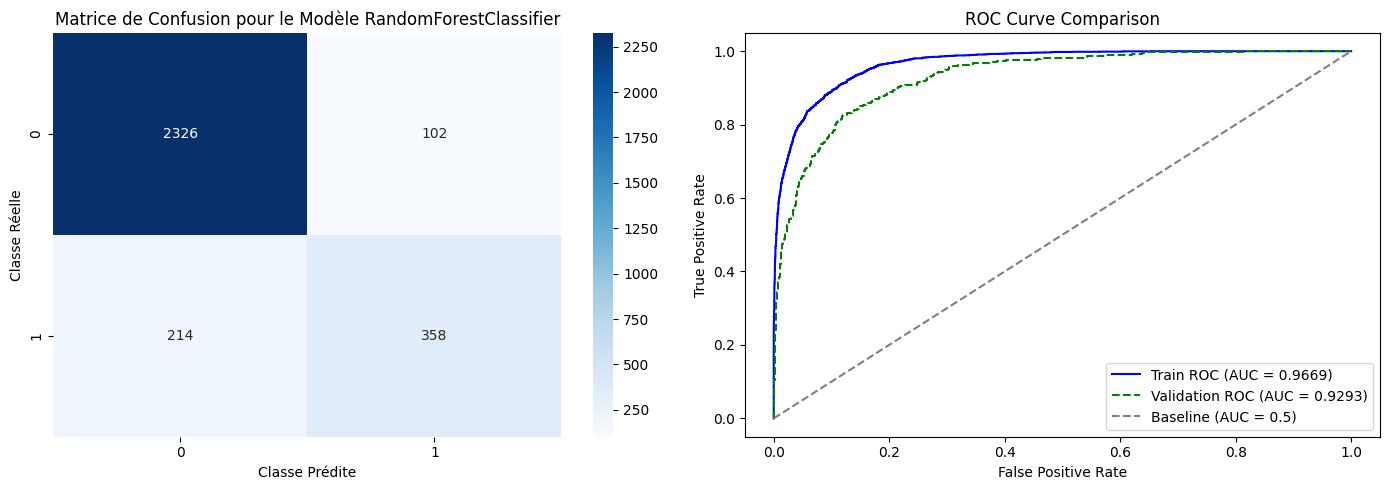

Classification Report for RandomForestClassifier:

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      2428
         1.0       0.78      0.63      0.69       572

    accuracy                           0.89      3000
   macro avg       0.85      0.79      0.82      3000
weighted avg       0.89      0.89      0.89      3000



In [223]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=rf_model_optuna,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

- **AUC Entraînement** : **0.9669** (très bon, pas de surapprentissage excessif).
- **AUC Validation** : **0.9293** (bonne généralisation).

- **Classe 0 (Non Sortie)** :
  - **Précision** : 92%, **Rappel** : 96%, **F1-score** : 0.94 (excellente performance).
- **Classe 1 (Sortie)** :
  - **Précision** : 78%, **Rappel** : 63%, **F1-score** : 0.69 (modéré, améliorable).

- **Accuracy** : **89%**, très bonne performance.
- **Macro avg F1** : **0.82**, équilibré entre les classes.

- Bonne généralisation et équilibre, mais le rappel pour la classe 1 peut être amélioré.

In [415]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_rf_optuna_base = save_predictions_to_csv(
    model=rf_model_optuna,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/rf_optuna_base.csv"
)

Predictions were saved in the file : ../data/val/rf_optuna_base.csv


In [416]:
predictions_final_random_forest = train_and_save_final_predictions(
    model=rf_model_optuna,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name='rf_optuna_final.pkl',
    output_file="../data/test/rf_optuna_final.csv"
)

Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/rf_optuna_final.pkl'...
Loaded pre-trained model from /home/chahla/Bank-Churn-Prediction/src/models/rf_optuna_final.pkl.
Predictions were saved in the file : ../data/test/rf_optuna_final.csv


# <span style="color:lightblue;">XGBoost</span>

#### Tuning des Hyperparametres avec Optuna

In [256]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),

        # Additional parameters to tune
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),  # Minimum loss reduction
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),  # L2 regularization
    }
    model = xgb.XGBClassifier(**params, random_state=42)
    model.fit(X_train_transformed, y_train)
    y_val_pred_prob = model.predict_proba(X_val_transformed)[:, 1]
    return roc_auc_score(y_val, y_val_pred_prob)

In [52]:
best_xgb_params, best_xgb_score, xgb_study = tune_hyperparameters(
    objective=objective_xgb,
    n_trials=0, # initially is 1000
    study_name="xgb_study_v2", 
    resume_study=True
)

[I 2024-12-22 17:35:00,968] A new study created in memory with name: no-name-bf189864-feb3-4ad3-9098-8a5a6b413b46


No previous study found. Starting new study 'xgb_study_v2'.


[I 2024-12-22 17:35:03,585] Trial 0 finished with value: 0.9270846534026106 and parameters: {'n_estimators': 631, 'max_depth': 6, 'learning_rate': 0.021203582901814053, 'subsample': 0.7264075877380543, 'colsample_bytree': 0.8996263097380887, 'min_child_weight': 5, 'gamma': 1.1412058927413775, 'reg_alpha': 1.6730822225298205, 'reg_lambda': 0.95255852202906}. Best is trial 0 with value: 0.9270846534026106.
[I 2024-12-22 17:35:04,565] Trial 1 finished with value: 0.9037604693494314 and parameters: {'n_estimators': 470, 'max_depth': 17, 'learning_rate': 0.1703901909152668, 'subsample': 0.557553476804062, 'colsample_bytree': 0.6937881054609231, 'min_child_weight': 3, 'gamma': 0.3460365174532054, 'reg_alpha': 0.6182824328194123, 'reg_lambda': 0.5183600810227473}. Best is trial 0 with value: 0.9270846534026106.
[I 2024-12-22 17:35:05,236] Trial 2 finished with value: 0.9225170936970771 and parameters: {'n_estimators': 916, 'max_depth': 11, 'learning_rate': 0.2335426205293937, 'subsample': 0.8

Study saved to xgb_study_v2.pkl
Best AUC: 0.931793700533404
Best Parameters: {'n_estimators': 181, 'max_depth': 3, 'learning_rate': 0.24591799488738436, 'subsample': 0.9732510688894012, 'colsample_bytree': 0.5321432847734856, 'min_child_weight': 10, 'gamma': 4.732167308437096, 'reg_alpha': 0.8690124261808367, 'reg_lambda': 1.7488380525207055}


In [383]:
# XGBoost
xgb_model_optuna = xgb.XGBClassifier(
    n_estimators=181,
    learning_rate=0.24591799488738436,
    max_depth=3,
    random_state=42,
    subsample= 0.9732510688894012, 
    colsample_bytree=0.5321432847734856,
    min_child_weight= 10, 
    gamma= 4.732167308437096, 
    reg_alpha= 0.8690124261808367, 
    reg_lambda=1.7488380525207055
)

auc_mean, auc_std = cross_validate_model(xgb_model_optuna, X_train_transformed, y_train)
xgb_model_optuna, auc_score_xgb_base = train_and_evaluate_model(xgb_model_optuna, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'xgb_optuna_base.pkl')

Starting cross-validation with 5 folds...
Scores AUC of each fold : [0.9296498259551944, 0.9359420073851591, 0.9444375549957729, 0.9433354828413189, 0.9330205403819941]
Mean of AUC scores : 0.9373
Standard Deviation of AUC scores : 0.0058
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/xgb_optuna_base.pkl'...
Loaded pre-trained model from /home/chahla/Bank-Churn-Prediction/src/models/xgb_optuna_base.pkl.
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/xgb_optuna_base.pkl.
AUC Score of the model XGBClassifier: 0.9318


AUC Score on Training Set: 0.9422
AUC Score on Validation Set: 0.9318


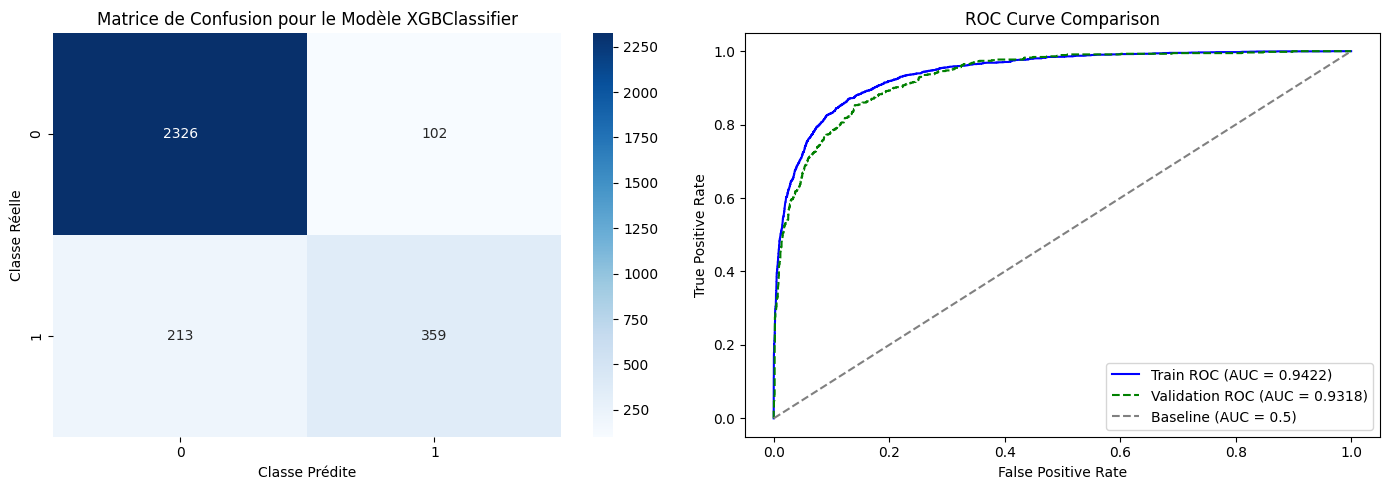

Classification Report for XGBClassifier:

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      2428
         1.0       0.78      0.63      0.70       572

    accuracy                           0.90      3000
   macro avg       0.85      0.79      0.82      3000
weighted avg       0.89      0.90      0.89      3000



In [258]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=xgb_model_optuna,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

- Les courbes ROC pour l'entraînement et la validation sont proches, confirmant une bonne stabilité et une généralisation du modèle.
- Le score AUC s'est amélioré

In [417]:
predictions_val_xgb_optuna_base = save_predictions_to_csv(
    model=xgb_model_optuna,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/xgb_optuna_base.csv"
)

Predictions were saved in the file : ../data/val/xgb_optuna_base.csv


In [418]:
predictions_final_xgb_optuna = train_and_save_final_predictions(
    model=xgb_model_optuna,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name='xgb_optuna_final.pkl',
    output_file="../data/test/xgb_optuna_final.csv"
)

Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/xgb_optuna_final.pkl'...
Loaded pre-trained model from /home/chahla/Bank-Churn-Prediction/src/models/xgb_optuna_final.pkl.
Predictions were saved in the file : ../data/test/xgb_optuna_final.csv


# <span style="color:lightblue;">LightGBM</span>

#### Finetuning des hyperparametres avec Optuna

In [270]:
def objective_lgb(trial):
    # params = {
    #     'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
    #     'num_leaves': trial.suggest_int('num_leaves', 20, 300),
    #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    #     'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0)
    # }

    params = {
    # Core hyperparameters
    'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
    'max_depth': trial.suggest_int('max_depth', 3, 20),
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
    
    # Sampling parameters
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'subsample_freq': trial.suggest_int('subsample_freq', 0, 10),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    
    # Regularization parameters
    'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 10.0),
    'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
    'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    
    # Advanced parameters
    'num_leaves': trial.suggest_int('num_leaves', 20, 200),
    'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
    
    # Boosting type
    'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
    
    # Loss function
    'objective': 'binary',
    'metric': 'auc',
    'class_weight' : 'balanced',

    'verbosity':-1,
    'verbose':-1
}

    model = lgb.LGBMClassifier(**params, random_state=42)
    model.fit(X_train_transformed, y_train)
    y_val_pred_prob = model.predict_proba(X_val_transformed)[:, 1]
    return roc_auc_score(y_val, y_val_pred_prob)


In [99]:
# best_lgb_params, best_lgb_score, lgb_study = tune_hyperparameters(
#     objective=objective_lgb,
#     n_trials=0, # initially was 1000
#     study_name="lgb_study", 
#     resume_study=True
# )

[I 2024-12-24 00:55:51,516] A new study created in memory with name: no-name-d70d9b01-35b4-4e95-bb21-706cff65b637


No previous study found. Starting new study 'lgb_study'.


[I 2024-12-24 00:55:51,986] Trial 0 finished with value: 0.9169659623737053 and parameters: {'n_estimators': 371, 'max_depth': 5, 'learning_rate': 0.3316047693090825, 'subsample': 0.9141620783908857, 'subsample_freq': 7, 'colsample_bytree': 0.9239325276098953, 'min_child_samples': 75, 'min_child_weight': 4.766203915171496, 'reg_alpha': 5.23921685144796, 'reg_lambda': 3.7881157808504, 'num_leaves': 170, 'feature_fraction': 0.8936241343685631, 'bagging_fraction': 0.7723904063123264, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.9169659623737053.
[I 2024-12-24 00:55:55,406] Trial 1 finished with value: 0.9264466999228119 and parameters: {'n_estimators': 402, 'max_depth': 17, 'learning_rate': 0.42779293731076923, 'subsample': 0.6394531425747261, 'subsample_freq': 2, 'colsample_bytree': 0.6499603354604202, 'min_child_samples': 27, 'min_child_weight': 2.5658834036456954, 'reg_alpha': 6.232173833189023, 'reg_lambda': 9.588019827665045, 'num_leaves': 123, 'feature_fraction': 0.753574

Study saved to /home/chahla/Bank-Churn-Prediction/src/study/lgb_study.pkl
Best AUC: 0.9308950933745004
Best Parameters: {'n_estimators': 723, 'max_depth': 3, 'learning_rate': 0.15956731063931848, 'subsample': 0.5473063602297252, 'subsample_freq': 3, 'colsample_bytree': 0.6011639351659629, 'min_child_samples': 12, 'min_child_weight': 9.584471648292249, 'reg_alpha': 8.165981459541023, 'reg_lambda': 9.80466886015553, 'num_leaves': 29, 'feature_fraction': 0.5504222510000222, 'bagging_fraction': 0.5001300500245465, 'boosting_type': 'dart'}


In [384]:
# LGB
lgb_model_optuna = lgb.LGBMClassifier(
    n_estimators=723,
    learning_rate=0.15956731063931848,
    max_depth=3,
    random_state=42,
    subsample= 0.5473063602297252, 
    subsample_freq = 3,
    colsample_bytree=0.6011639351659629,
    min_child_samples= 12,
    min_child_weight= 9.584471648292249, 
    reg_alpha= 8.165981459541023, 
    reg_lambda=9.80466886015553,
    num_leaves= 29,
    feature_fraction= 0.5504222510000222, 
    bagging_fraction= 0.5001300500245465, 
    boosting_type= 'dart',
    class_weight = 'balanced',
    verbose = -1,
    verbosity = -1
)

auc_mean, auc_std = cross_validate_model(lgb_model_optuna, X_train_transformed, y_train)
lgb_model_optuna, auc_score_lgb_base = train_and_evaluate_model(lgb_model_optuna, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'lgb_optuna_base.pkl')

Starting cross-validation with 5 folds...
Scores AUC of each fold : [0.9257282827399179, 0.9363988547495385, 0.9419654410876653, 0.9407188702358564, 0.9328577097603479]
Mean of AUC scores : 0.9355
Standard Deviation of AUC scores : 0.0059
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/lgb_optuna_base.pkl'...
Loaded pre-trained model from /home/chahla/Bank-Churn-Prediction/src/models/lgb_optuna_base.pkl.
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/lgb_optuna_base.pkl.
AUC Score of the model LGBMClassifier: 0.9309


AUC Score on Training Set: 0.9465
AUC Score on Validation Set: 0.9309


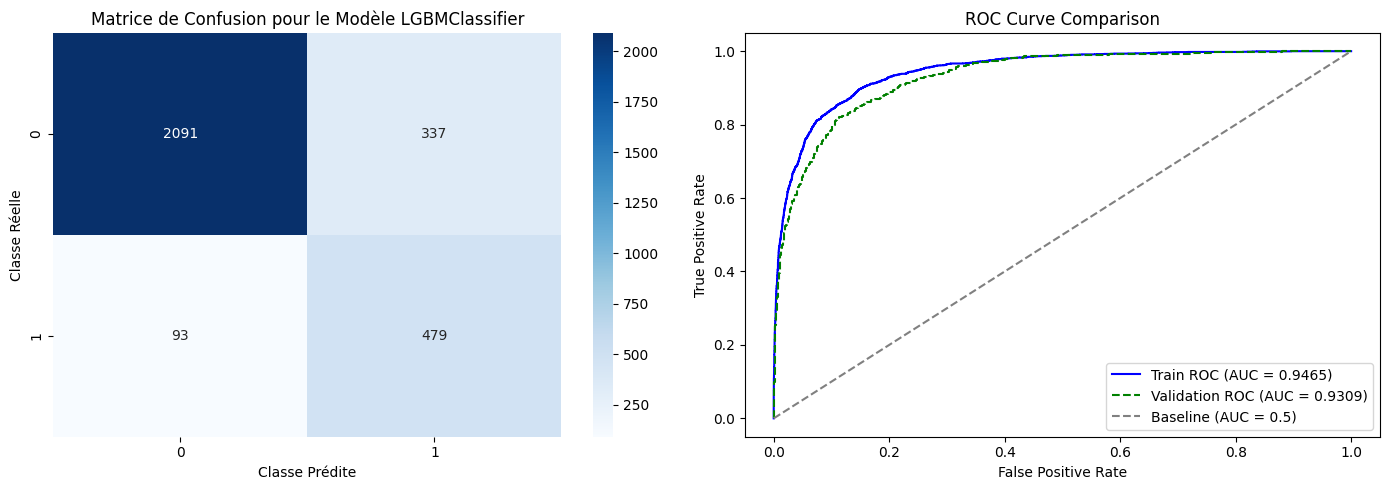

Classification Report for LGBMClassifier:

              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91      2428
         1.0       0.59      0.84      0.69       572

    accuracy                           0.86      3000
   macro avg       0.77      0.85      0.80      3000
weighted avg       0.89      0.86      0.87      3000



In [271]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=lgb_model_optuna,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

- AUC Scores : Très bons résultats avec 0.9465 (train) et 0.9309 (validation), montrant une bonne généralisation.
- Classe 0: Très bien prédite avec peu d’erreurs.
- Classe 1: Bonne détection avec un rappel élevé (84%), mais encore des erreurs.
- Modèle performant, stable, et efficace pour détecter les churners malgré le déséquilibre des classes.

In [419]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_lgb_optuna_base = save_predictions_to_csv(
    model=lgb_model_optuna,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/lgb_optuna_base.csv"
)

Predictions were saved in the file : ../data/val/lgb_optuna_base.csv


In [420]:
predictions_final_lgb_optuna = train_and_save_final_predictions(
    model=lgb_model_optuna,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name='lgb_optuna_final.pkl',
    output_file="../data/test/lgb_optuna_final.csv"
)

Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/lgb_optuna_final.pkl'...
No pre-trained model found. Training model from scratch...
The model LGBMClassifier is trained on the full train dataset
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/lgb_optuna_final.pkl.
Predictions were saved in the file : ../data/test/lgb_optuna_final.csv


# <span style="color:lightblue;">CatBoost</span>

#### Test des résultat sur l'ensemble de validation

In [385]:
catboost_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=5,
    verbose=0,
    random_state=42
)

auc_mean, auc_std = cross_validate_model(catboost_model, X_train_transformed, y_train)
catboost_model, auc_score_catboost_base = train_and_evaluate_model(catboost_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'catboost_base.pkl')

Starting cross-validation with 5 folds...
Scores AUC of each fold : [0.930223315199841, 0.9364420554459337, 0.9426771510895632, 0.9447659121102849, 0.9361790231025382]
Mean of AUC scores : 0.9381
Standard Deviation of AUC scores : 0.0052
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/catboost_base.pkl'...
Loaded pre-trained model from /home/chahla/Bank-Churn-Prediction/src/models/catboost_base.pkl.
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/catboost_base.pkl.
AUC Score of the model CatBoostClassifier: 0.9311


AUC Score on Training Set: 0.9444
AUC Score on Validation Set: 0.9311


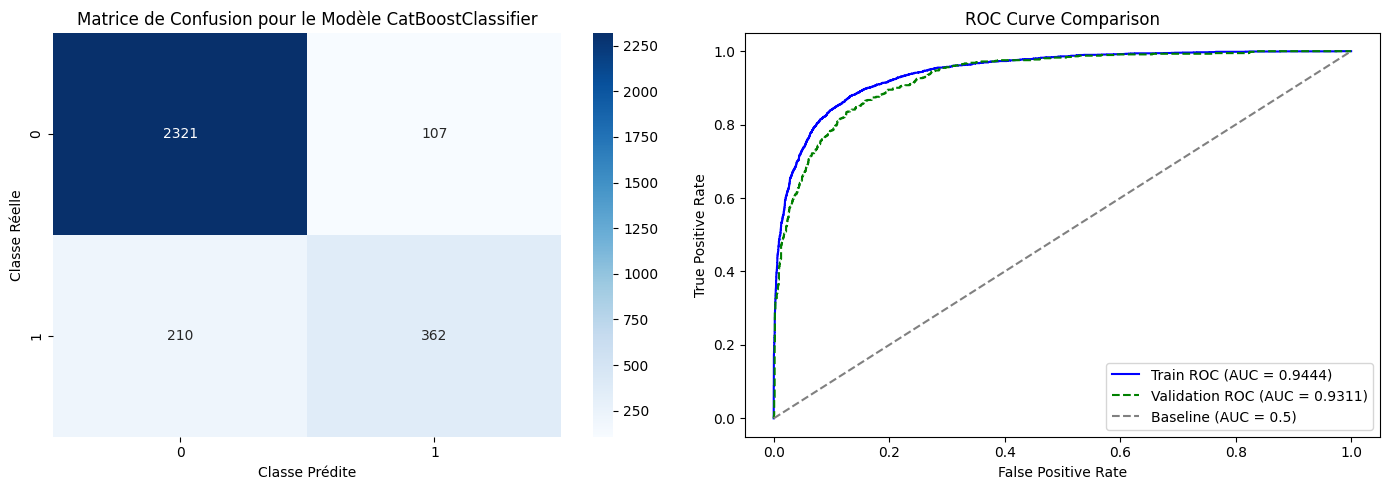

Classification Report for CatBoostClassifier:

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      2428
         1.0       0.77      0.63      0.70       572

    accuracy                           0.89      3000
   macro avg       0.84      0.79      0.82      3000
weighted avg       0.89      0.89      0.89      3000



In [275]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=catboost_model,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

- Le modèle CatBoost montre une excellente performance avec un AUC de 0.9444 sur l'ensemble d'entraînement et 0.9311 sur l'ensemble de validation, confirmant une bonne généralisation.

In [425]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_catboost_base = save_predictions_to_csv(
    model=catboost_model,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/catboost_base.csv"
)

Predictions were saved in the file : ../data/val/catboost_base.csv


#### Sur l'ensemble test

In [426]:
predictions_final_catboost = train_and_save_final_predictions(
    model=catboost_model,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name = 'catboost_final.pkl',
    output_file="../data/test/catboost_final.csv"
)

Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/catboost_final.pkl'...
Loaded pre-trained model from /home/chahla/Bank-Churn-Prediction/src/models/catboost_final.pkl.
Predictions were saved in the file : ../data/test/catboost_final.csv


#### Finetuning des hyperparametres avec Optuna

In [278]:
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 200),  # Restrict range
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Reduce range
        'depth': trial.suggest_int('depth', 4, 6),  # Reduce range
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 5),  # Reduce range
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # Standard range
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),  # Reasonable range
        'rsm': trial.suggest_float('rsm', 0.7, 1.0),  # Smaller range
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'grow_policy': 'Depthwise',
    }

    model = CatBoostClassifier(**params, verbose=0, random_state=42)
    model.fit(X_train_transformed, y_train, eval_set=(X_val_transformed, y_val), early_stopping_rounds=50)

    y_val_pred_prob = model.predict_proba(X_val_transformed)[:, 1]
    auc_score = roc_auc_score(y_val, y_val_pred_prob)
    
    print(f"Trial {trial.number}: AUC = {auc_score:.4f} | Params = {params}")
    trial.report(auc_score, step=trial.number)
    
    return auc_score

In [282]:
best_catboost_params, best_catboost_score, catboost_study = tune_hyperparameters(
    objective=objective_catboost,
    n_trials=0, # initially was 2000
    study_name="catboost_study", 
    resume_study=True
)

Resuming previous study 'catboost_study' with 3000 trials.
Study saved to /home/chahla/Bank-Churn-Prediction/src/study/catboost_study.pkl
Best AUC: 0.9319758700936625
Best Parameters: {'iterations': 67, 'learning_rate': 0.19715885936728017, 'depth': 4, 'l2_leaf_reg': 4.4125016526853305, 'subsample': 0.8671564652762658, 'min_data_in_leaf': 26, 'rsm': 0.9732160473984149}


In [283]:
catboost_model_optuna = CatBoostClassifier(
    iterations=67,
    learning_rate=0.19715885936728017,
    depth=4,
    l2_leaf_reg= 4.4125016526853305,
    subsample= 0.8671564652762658, 
    min_data_in_leaf= 26,
    rsm =0.9732160473984149,
    verbose=0
)

auc_mean, auc_std = cross_validate_model(catboost_model_optuna, X_train_transformed, y_train)
catboost_model_optuna, auc_score_catboost_base = train_and_evaluate_model(catboost_model_optuna, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'catboost_optuna_base.pkl')

Starting cross-validation with 5 folds...
Scores AUC of each fold : [0.9297281272174106, 0.9365786776482837, 0.9435635535464724, 0.9448289954968168, 0.9353875153125486]
Mean of AUC scores : 0.9380
Standard Deviation of AUC scores : 0.0056
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/catboost_optuna_base.pkl'...
Loaded pre-trained model from /home/chahla/Bank-Churn-Prediction/src/models/catboost_optuna_base.pkl.
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/catboost_optuna_base.pkl.
AUC Score of the model CatBoostClassifier: 0.9307


In [403]:
catboost_model_optuna = CatBoostClassifier(
    iterations=67,
    learning_rate=0.19715885936728017,
    depth=4,
    l2_leaf_reg= 4.4125016526853305,
    subsample= 0.8671564652762658, 
    min_data_in_leaf= 26,
    rsm =0.9732160473984149,
)

auc_mean, auc_std = cross_validate_model(catboost_model_optuna, X_train_transformed, y_train)
catboost_model_optuna, auc_score_catboost_base = train_and_evaluate_model(catboost_model_optuna, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'catboost_optuna_base.pkl')

Starting cross-validation with 5 folds...
0:	learn: 0.5783647	total: 2.29ms	remaining: 151ms
1:	learn: 0.4999181	total: 3.42ms	remaining: 111ms
2:	learn: 0.4469490	total: 4.63ms	remaining: 98.7ms
3:	learn: 0.4081992	total: 5.88ms	remaining: 92.7ms
4:	learn: 0.3782260	total: 11.1ms	remaining: 138ms
5:	learn: 0.3524817	total: 12.7ms	remaining: 129ms
6:	learn: 0.3310398	total: 14.1ms	remaining: 121ms
7:	learn: 0.3165587	total: 18.2ms	remaining: 134ms
8:	learn: 0.3045785	total: 20.1ms	remaining: 129ms
9:	learn: 0.2974275	total: 21.2ms	remaining: 121ms
10:	learn: 0.2891546	total: 23.2ms	remaining: 118ms
11:	learn: 0.2790596	total: 28.4ms	remaining: 130ms
12:	learn: 0.2718433	total: 29.9ms	remaining: 124ms
13:	learn: 0.2666055	total: 31.1ms	remaining: 118ms
14:	learn: 0.2636294	total: 32.1ms	remaining: 111ms
15:	learn: 0.2586420	total: 33.6ms	remaining: 107ms
16:	learn: 0.2558855	total: 34.9ms	remaining: 103ms
17:	learn: 0.2532101	total: 39.7ms	remaining: 108ms
18:	learn: 0.2517349	total: 45

AUC Score on Training Set: 0.9431
AUC Score on Validation Set: 0.9307


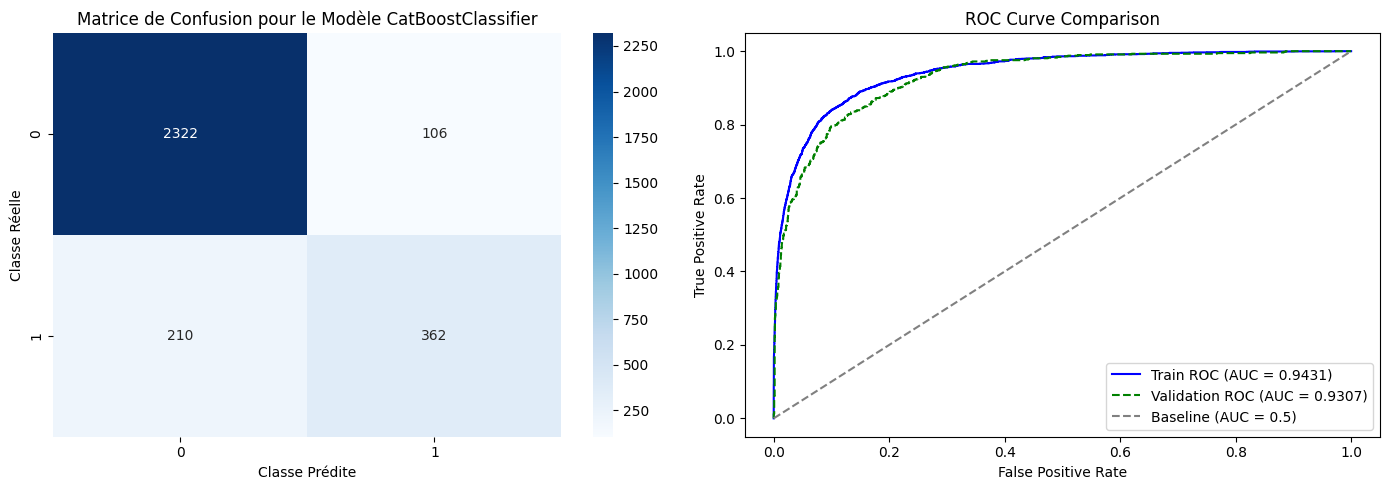

Classification Report for CatBoostClassifier:

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      2428
         1.0       0.77      0.63      0.70       572

    accuracy                           0.89      3000
   macro avg       0.85      0.79      0.82      3000
weighted avg       0.89      0.89      0.89      3000



In [284]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=catboost_model_optuna,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

Malgré le tuning des hyperparamètres, le meilleur score AUC du modèle CatBoost est resté stable à 0.9311 sur l'ensemble de validation. Cela peut être dû à deux raisons principales :

- **Nombre limité de trials avec Optuna :** Aavec le nombre actuel d'essais, Optuna n'a pas exploré toutes les combinaisons d'hyperparamètres qui pourraient potentiellement améliorer les performances du modèle.
- **Limite intrinsèque du modèle :** Ce résultat pourrait également représenter le maximum que ce modèle peut atteindre avec les données et les caractéristiques actuelles. Dans ce cas, d'autres stratégies sont nécessaires, comme le stacking avec d'autres modèles ou le feature engineering.

In [423]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_catboost_base = save_predictions_to_csv(
    model=catboost_model_optuna,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/catboost_optuna_base.csv"
)

Predictions were saved in the file : ../data/val/catboost_optuna_base.csv


In [424]:
predictions_final_catboost = train_and_save_final_predictions(
    model=catboost_model_optuna,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name = 'catboost_optuna_final.pkl',
    output_file="../data/test/catboost_optuna_final.csv"
)

Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/catboost_optuna_final.pkl'...
Loaded pre-trained model from /home/chahla/Bank-Churn-Prediction/src/models/catboost_optuna_final.pkl.
Predictions were saved in the file : ../data/test/catboost_optuna_final.csv


# <span style="color:lightblue;">Blending</span>

In [314]:
models = [catboost_model_optuna, xgb_model_optuna, lgb_model_optuna, rf_model_optuna]

In [396]:
def weight_search(models, X, y, cv_folds=5, weight_step=0.1, verbose=True):
    print("Starting weight search...")
    best_weights = None
    best_auc = -np.inf
    
    # Generate weight combinations
    weights = np.arange(0, 1 + weight_step, weight_step)
    weight_combinations = [comb for comb in product(weights, repeat=len(models)) if np.allclose(sum(comb), 1.0)]
    
    print(f"Total weight combinations to try: {len(weight_combinations)}")
    
    for comb in weight_combinations:
        if verbose:
            print(f"Testing weight combination: {comb}")
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        auc_scores = []
        
        for train_index, val_index in skf.split(X, y):
            # Split the data
            X_train, X_val = X.iloc[train_index], X.iloc[val_index] if isinstance(X, pd.DataFrame) else (X[train_index], X[val_index])
            y_train, y_val = y.iloc[train_index], y.iloc[val_index] if isinstance(y, pd.Series) else (y[train_index], y[val_index])

            fold_preds = np.zeros(len(y_val), dtype=np.float64)
            
            # Train each model and blend predictions
            for model, weight in zip(models, comb):
                model.fit(X_train, y_train)
                y_val_pred_prob = model.predict_proba(X_val)[:, 1]
                fold_preds += weight * y_val_pred_prob
            
            # Evaluate blended predictions
            auc_score = roc_auc_score(y_val, fold_preds)
            auc_scores.append(auc_score)
        
        # Calculate mean AUC for this weight combination
        mean_auc = np.mean(auc_scores)
        if verbose:
            print(f"Mean AUC for weights {comb}: {mean_auc:.4f}")
        
        # Update the best weights if this combination is better
        if mean_auc > best_auc:
            best_auc = mean_auc
            best_weights = comb
    
    print(f"Best weights: {best_weights}")
    print(f"Best AUC: {best_auc:.4f}")
    return best_weights, best_auc

In [435]:
class BlendedModel:
    def __init__(self, models, weights):
        """
        Initialise le modèle blended.
        """
        self.models = models
        self.weights = weights

    def fit(self, X, y):
        """
        Entraîne chaque modèle avec les données fournies.
        """
        for model in self.models.values():
            model.fit(X, y)

    def predict_proba(self, X):
        """
        Calcule les probabilités blended.
        """
        blended_probs = np.zeros(len(X), dtype=np.float64)
        for (name, model), weight in zip(self.models.items(), self.weights):
            if weight > 0:
                blended_probs += weight * model.predict_proba(X)[:, 1]
        return np.column_stack((1 - blended_probs, blended_probs))

    def predict(self, X):
        """
        Prédit la classe basée sur les probabilités blended.
        """
        probs = self.predict_proba(X)[:, 1]
        return (probs >= 0.5).astype(int)

In [441]:
def save_blended_predictions_to_csv(models, best_weights, X_train, y_train, X_test, test_id, output_file):
    print("Génération du fichier de soumission avec des prédictions mélangées...")
    blended_test_preds = np.zeros(len(X_test), dtype=np.float64)
    
    # Train each model and predict on the test set
    for model, weight in zip(models, best_weights):  # Suppression de .items()
        if weight > 0:  # Entraîner uniquement les modèles avec des poids non nuls
            print(f"Entraînement du modèle {model} avec un poids de {weight}...")
            model.fit(X_train, y_train)
            test_preds = model.predict_proba(X_test)[:, 1]
            blended_test_preds += weight * test_preds
    
    # Prepare the submission DataFrame
    submission = pd.DataFrame({
        "id": test_id,
        "Exited": blended_test_preds
    })
    
    # Save to CSV
    submission.to_csv(output_file, index=False)
    print(f"Fichier de soumission enregistré sous {output_file}")

In [322]:
best_weights, best_auc = weight_search(models, X_train_transformed, y_train, cv_folds=5, weight_step=0.1)

Starting weight search...
Total weight combinations to try: 286
Testing weight combination: (0.0, 0.0, 0.0, 1.0)
Mean AUC for weights (0.0, 0.0, 0.0, 1.0): 0.9343
Testing weight combination: (0.0, 0.0, 0.1, 0.9)
Mean AUC for weights (0.0, 0.0, 0.1, 0.9): 0.9351
Testing weight combination: (0.0, 0.0, 0.2, 0.8)
Mean AUC for weights (0.0, 0.0, 0.2, 0.8): 0.9357
Testing weight combination: (0.0, 0.0, 0.30000000000000004, 0.7000000000000001)
Mean AUC for weights (0.0, 0.0, 0.30000000000000004, 0.7000000000000001): 0.9360
Testing weight combination: (0.0, 0.0, 0.4, 0.6000000000000001)
Mean AUC for weights (0.0, 0.0, 0.4, 0.6000000000000001): 0.9361
Testing weight combination: (0.0, 0.0, 0.5, 0.5)
Mean AUC for weights (0.0, 0.0, 0.5, 0.5): 0.9362
Testing weight combination: (0.0, 0.0, 0.6000000000000001, 0.4)
Mean AUC for weights (0.0, 0.0, 0.6000000000000001, 0.4): 0.9362
Testing weight combination: (0.0, 0.0, 0.7000000000000001, 0.30000000000000004)
Mean AUC for weights (0.0, 0.0, 0.7000000

In [442]:
# Use the save_blended_predictions_to_csv function with the best weights
output_file = "../data/test/blending.csv"

# Prepare the models (ensure they are the same models used during weight search)
models_dict = {
    "CatBoost": catboost_model_optuna,
    "XGBoost": xgb_model_optuna,
    "LightGBM" : lgb_model_optuna,
    "RandomForest": rf_model_optuna
}

# Filter models with non-zero weights for efficiency
filtered_models = [
    model for model, weight in zip(models_dict.values(), (0.8, 0.1, 0.0, 0.1)) if weight > 0
]

filtered_weights = [weight for weight in (0.8, 0.1, 0.0, 0.1) if weight > 0]

# Generate and save predictions
save_blended_predictions_to_csv(
    models=filtered_models,          # Use filtered models
    best_weights=filtered_weights,   # Use corresponding weights for non-zero models
    X_train=X_train_transformed,
    y_train=y_train,
    X_test=test_transformed,
    test_id=test['id'],
    output_file=output_file
)

print(f"Submission file saved as {output_file}")

Génération du fichier de soumission avec des prédictions mélangées...
Entraînement du modèle <catboost.core.CatBoostClassifier object at 0x7fc2dd3f3110> avec un poids de 0.8...
Entraînement du modèle XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5321432847734856, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=4.732167308437096,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.24591799488738436,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=181, n_jobs=None,
              num_parallel_tree=None, random_state=42,

In [443]:
blended_model = BlendedModel(models=models_dict, weights=(0.8, 0.1, 0.0, 0.1))

AUC Score on Training Set: 0.9474
AUC Score on Validation Set: 0.9313


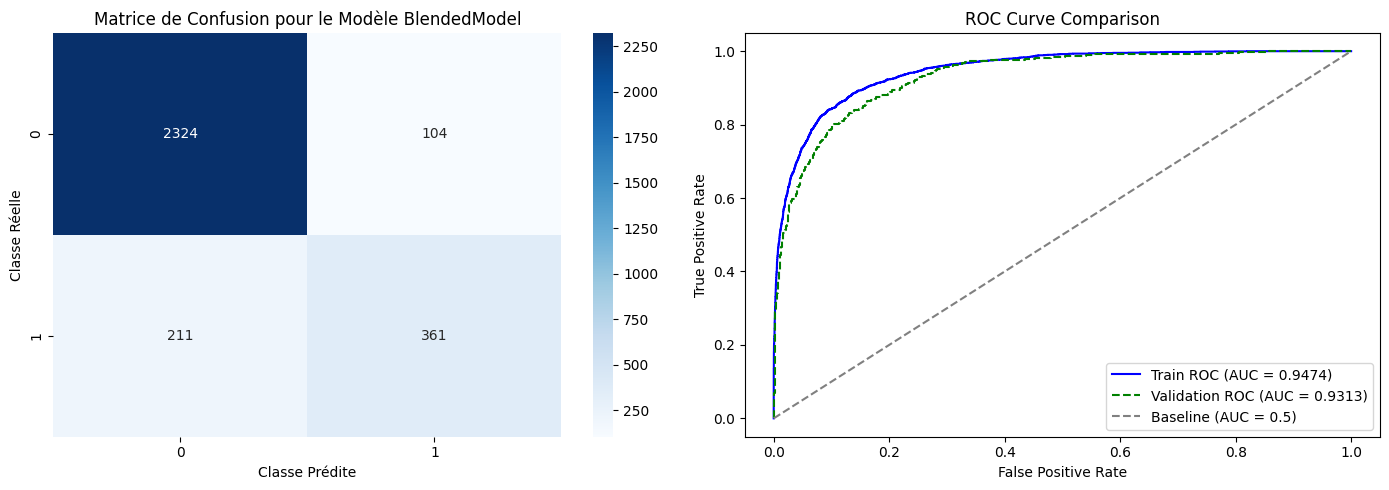

Classification Report for BlendedModel:

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      2428
         1.0       0.78      0.63      0.70       572

    accuracy                           0.90      3000
   macro avg       0.85      0.79      0.82      3000
weighted avg       0.89      0.90      0.89      3000



In [444]:
# Évaluation du modèle blended
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=blended_model,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

Le blending, bien qu'il n'a pas donné les meilleurs résultats sur le validation set, mais il a bien performé sur kaggle.

## Conclusion

Malgré les efforts déployés pour explorer et tester différentes approches, les performances obtenues restent limitées, en grande partie à cause du fait que nos ordinateurs personnels sont peu adaptées à des tâches de calcul intensif, ce qui a fortement restreint nos capacités à effectuer des essais approfondis et des optimisations poussées.

Dans ce projet, nous avons néanmoins tenté de maximiser les ressources disponibles en expérimentant plusieurs méthodes :

- Différents modèles de base : régression logistique, SVM, KNN, Catboost, XGBoost, LightgGBM, etc.
- Techniques avancées : stacking, AutoML (H2O), et l'équilibrage des classes avec SMOTE.
- Feature Engineering : pour améliorer la qualité des données et augmenter la performance des modèles.

Cependant, aucune de ces approches n'a permis d'améliorer significativement les scores. Il est probable qu'avec des ressources informatiques plus puissantes, nous aurions pu explorer davantage les hyperparamètres, notamment avec Optuna, pour effectuer un fine-tuning plus poussé.